# **UBIT: 50611344 Name: Tharunnesh Ramamoorthy**

In [39]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
file_path = "Data.csv"
df = pd.read_csv(file_path)

In [ ]:

# 1) Handle missing values in essential columns 
df_cleaned = df.dropna(subset=['latitude', 'popular_times', 'longitude', 'rating'])

# 2) Converting Cities and States to a unified format
df_cleaned['city'] = df_cleaned['city'].str.lower()
df_cleaned['us_state'] = df_cleaned['us_state'].str.lower()
df_cleaned['city'] = df_cleaned['city'].str.capitalize()
df_cleaned['us_state'] = df_cleaned['us_state'].str.capitalize()

# #3) Normalizing the working hours for time consistent format
df_cleaned['working_hours'] = df_cleaned['working_hours'].astype(str)
df_cleaned['working_hours'] = df_cleaned['working_hours'].apply(lambda x: re.sub(r'[a-zA-Z\s]+', '', x))
df_cleaned['working_hours'] = df_cleaned['working_hours'].fillna('Unknown')

# Function to calculate weekday hours from the 'working_hours' column
def get_weekday_hours(working_hours):
    try:
        # Split the string by colons
        parts = working_hours.split(':')
        # Extract weekday hours (Monday to Friday are typically the first 5 sections)
        weekday_parts = parts[1:6]
        # Count non-empty time ranges in the first 5 parts
        weekday_hours = sum(1 for part in weekday_parts if part.strip())
        return weekday_hours
    except Exception as e:
        return 0  # Default to 0 if there's an error

# Function to calculate weekend hours from the 'working_hours' column
def get_weekend_hours(working_hours):
    try:
        # Split the string by colons
        parts = working_hours.split(':')
        # Extract weekend hours (Saturday and Sunday are typically the 6th and 7th sections)
        weekend_parts = parts[5:7]
        # Count non-empty time ranges in the 6th and 7th parts
        weekend_hours = sum(1 for part in weekend_parts if part.strip())
        return weekend_hours
    except Exception as e:
        return 0  # Default to 0 if there's an error

# Apply the functions to the 'working_hours' column to calculate weekday and weekend hours
df_cleaned['weekday_hours'] = df_cleaned['working_hours'].apply(get_weekday_hours)
df_cleaned['weekend_hours'] = df_cleaned['working_hours'].apply(get_weekend_hours)

# 4) Making the names uniform by applying title case
df_cleaned['name'] = df_cleaned['name'].str.title()

# 5) Removing invalid latitude and longitude range and bringing precision to them
df_cleaned = df_cleaned[(df_cleaned['latitude'].between(-90, 90)) & (df_cleaned['longitude'].between(-180, 180))]
df_cleaned['latitude'] = df_cleaned['latitude'].round(6)
df_cleaned['longitude'] = df_cleaned['longitude'].round(6)

# 6) Creating a new column 'rating_category' based on 'rating' (with tiers as low, medium, high)
df_cleaned['rating_category'] = pd.cut(df_cleaned['rating'], bins=[0, 3, 4.5, 5], labels=['Low', 'Medium', 'High'])

# 7) Removing the whitespace from following columns
df_cleaned['name'] = df_cleaned['name'].str.strip()
df_cleaned['city'] = df_cleaned['city'].str.strip()

# 8) Introducing a new column 'is_weekend_open' based on 'working_hours' to check if locations are open on weekends
def has_values_after_colon(working_hours):
    try:
        # Split the string by colon and check if there are values after the 6th and 7th positions
        parts = working_hours.split(':')
        if len(parts) > 6 and parts[6].strip():  # Check 7th part exists and is not empty
            return True  # There's a value after the 6th colon
        if len(parts) > 7 and parts[7].strip():  # Check 8th part exists and is not empty
            return True  # There's a value after the 7th colon
        return False
    except Exception as e:
        # In case of any issue, return False
        return False

# Apply the function to detect if there are values after the 6th and 7th colons
df_cleaned['is_weekend_open'] = df_cleaned['working_hours'].apply(has_values_after_colon)

# 9) Convertings 'rating' column to numeric data if any inconsitency
df_cleaned['rating'] = pd.to_numeric(df_cleaned['rating'], errors='coerce')
df_cleaned = df_cleaned.dropna(subset=['rating'])

# 10) Creating columns 'weekday_hours'and 'weekend_hours'
df_cleaned['working_hours'] = df_cleaned['working_hours'].apply(lambda x: re.sub(r'[^\d:-]', '', x))
df_cleaned['weekday_hours'] = df_cleaned['working_hours'].apply(get_weekday_hours)
df_cleaned['weekend_hours'] = df_cleaned['working_hours'].apply(get_weekend_hours)
# 11 Standardize the 'rating' column by scaling it to a range of 0 to 5
df_cleaned['rating_scaled'] = (df_cleaned['rating'] / df_cleaned['rating'].max()) * 5
df_cleaned['popular_times'] = df_cleaned['popular_times'].apply(lambda x: eval(x) if isinstance(x, str) else x)
df_cleaned = df_cleaned[df_cleaned['popular_times'].apply(lambda x: isinstance(x, list) and len(x) == 7)]

results = []

for idx, row in df_cleaned.iterrows():
    popular_times = row['popular_times'] 
    df = pd.DataFrame(popular_times, index=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
    df.columns = [f'{hour:02d}:00' for hour in range(24)]
    
    daily_avg_popularity = df.mean(axis=1)
    busiest_hours = df.idxmax(axis=1)
    overall_avg_popularity = df.values.mean()
    weekday_popularity = df.loc['Monday':'Friday'].mean().mean()
    weekend_popularity = df.loc[['Saturday', 'Sunday']].mean().mean()
    weekday_weekend_ratio = weekday_popularity / weekend_popularity if weekend_popularity else 100  

    results.append({
        'name': row['name'],
        'daily_avg_popularity': daily_avg_popularity.tolist(),
        'busiest_hours': busiest_hours.tolist(),
        'overall_avg_popularity': overall_avg_popularity,
        'weekday_weekend_ratio': weekday_weekend_ratio
    })


results_df = pd.DataFrame(results)

df_cleaned = df_cleaned.merge(
    results_df[['name', 'daily_avg_popularity', 'busiest_hours', 'overall_avg_popularity', 'weekday_weekend_ratio']], 
    on='name'
)

print("Updated DataFrame with Popularity Metrics:")
print(df_cleaned.head())



EXPLANATION AND ANALYSIS

Problem 1: Finding the 5 nearest Places based on crowd Density Using Ball Tree.
• Here First, Ball tree algorithm is for finding the nearest–neighbor search. Usually, it will works on high dimensional spaces and geospatial data.

• In this algorithm, we are using a geographical coordinates like latitude and longitude. And also we are mainly focusing on the crowd density. So Ball tree is the best option compared to other
algorithms.

• So here we need to find the 5 nearest places based on crowd density. So by using this it will reduces the time complexity.

Tuning and Training:
• Here we need to select the right distant metric. In this algorithm we used Euclidean distance metric. It will cover the geospatial proximity and crowd density. So this will find the nearby tourist spots and it will shows the crowd density places.

Effectiveness:

• Here the ball tree algorithms provide a efficient and fast by identifying 5 nearest places for each location. And also it is more Effective than other algorithms.

• By doing this we can find the lower crowd densities. This will gives the recommendations for less crowded spots.

• After that we are doing the Average Distance to nearest neighbor’s, So this will helps to find the nearest location and their neighbors.

Secondly, we compared every locations crowd density to the average density of the 5 nearest neighbors. This will determine if the nearby locations and revealing the patterns of crowd distribution across different tourist spots.

Finally, ball tree seems to be suitable algorithm to identify the geo spatial patterns in tourist spots. 

Overall Average Distance to 5 Nearest Neighbors: 1.317112503825265


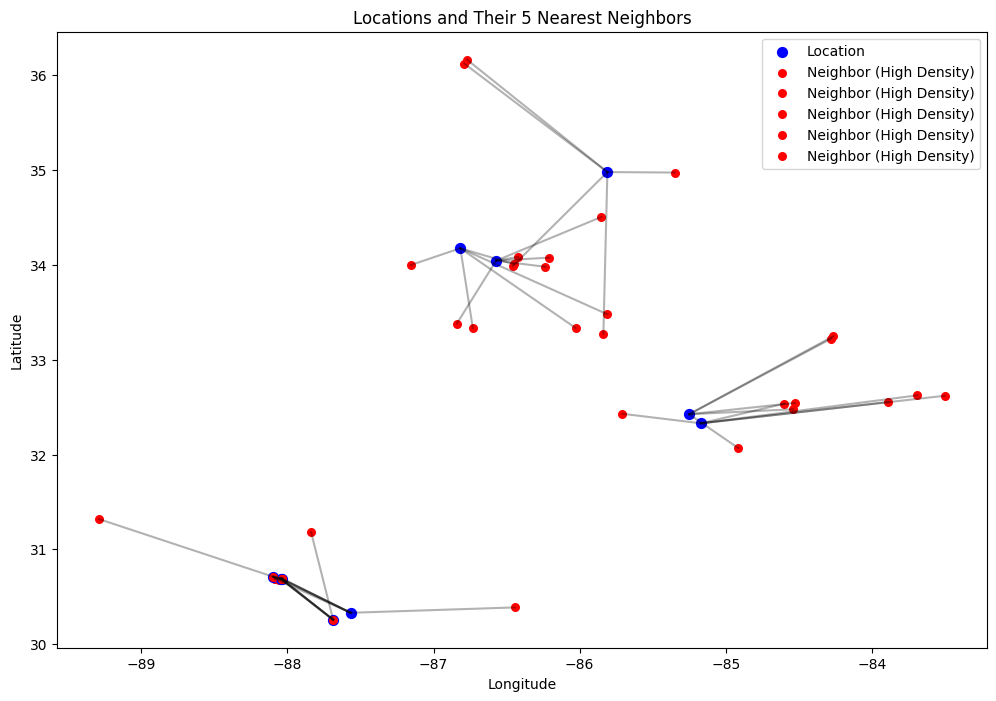

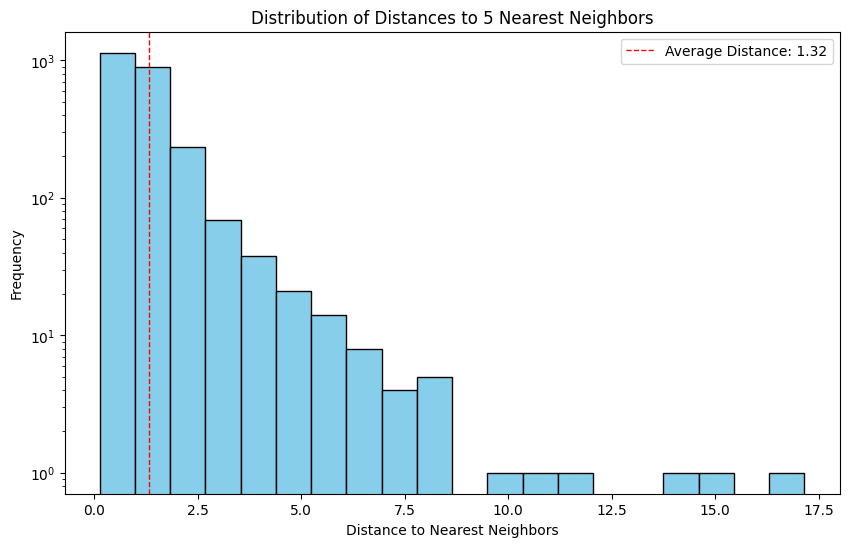

True densities: [13.08333333 12.63095238 14.27380952 14.07738095 14.2202381 ]
Average neighbor densities: [12.76666667 13.03452381 13.8452381  13.98690476 14.11190476]
Mean Squared Error (MSE): 0.6616686784498348
Mean Absolute Error (MAE): 0.41424454508027986


In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import BallTree

coords = df_cleaned[['latitude', 'longitude']].to_numpy()
crowd_density = df_cleaned['overall_avg_popularity'].to_numpy().reshape(-1, 1)

tree = BallTree(np.hstack((coords, crowd_density)), metric='euclidean')

distances, indices = tree.query(np.hstack((coords, crowd_density)), k=6) 

average_distance = []
density_comparison = []
neighbor_data = []

for i, (dist, idx) in enumerate(zip(distances, indices)):
    avg_dist_to_neighbors = np.mean(dist[1:])
    avg_density_of_neighbors = np.mean(crowd_density[idx[1:]])
    
    average_distance.append(avg_dist_to_neighbors)
    density_comparison.append((crowd_density[i][0], avg_density_of_neighbors))
    
    neighbors = [(coords[j][0], coords[j][1], crowd_density[j][0], dist[k])
                 for k, j in enumerate(idx[1:], start=1)]
    neighbor_data.append({
        'location': (coords[i][0], coords[i][1]),
        'neighbors': neighbors
    })

overall_avg_distance = np.mean(average_distance)
print("Overall Average Distance to 5 Nearest Neighbors:", overall_avg_distance)

plt.figure(figsize=(12, 8))
for data in neighbor_data[:10]:  
    loc_lat, loc_long = data['location']
    plt.scatter(loc_long, loc_lat, color='blue', s=50, label='Location' if data == neighbor_data[0] else "")
    
    for neighbor in data['neighbors']:
        neighbor_lat, neighbor_long, neighbor_density, dist = neighbor
        plt.plot([loc_long, neighbor_long], [loc_lat, neighbor_lat], 'k-', alpha=0.3)  # Connect with line
        plt.scatter(neighbor_long, neighbor_lat, color='red' if neighbor_density > 0.25 else 'green', s=30,
                    label='Neighbor (High Density)' if neighbor_density > 0.25 and data == neighbor_data[0] else "")
        
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Locations and Their 5 Nearest Neighbors")
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(average_distance, bins=20, color='skyblue', edgecolor='black')
plt.axvline(overall_avg_distance, color='red', linestyle='dashed', linewidth=1, label=f'Average Distance: {overall_avg_distance:.2f}')
plt.xlabel("Distance to Nearest Neighbors")
plt.ylabel("Frequency")
plt.yscale('log')
plt.title("Distribution of Distances to 5 Nearest Neighbors")
plt.legend()
plt.show()
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


true_densities = []
for density in crowd_density:
    try:
        true_densities.append(float(density[0]))
    except ValueError:
        true_densities.append(0)  

true_densities = np.array(true_densities)

avg_neighbor_densities = []
for neighbors in neighbor_data:
    try:
        avg_density = np.mean([float(neighbor[2]) for neighbor in neighbors['neighbors']])
        avg_neighbor_densities.append(avg_density)
    except ValueError:
        avg_neighbor_densities.append(0)  

avg_neighbor_densities = np.array(avg_neighbor_densities)

print("True densities:", true_densities[:5])  
print("Average neighbor densities:", avg_neighbor_densities[:5])

mse = mean_squared_error(true_densities, avg_neighbor_densities)

mae = np.mean(np.abs(true_densities - avg_neighbor_densities))

results = {
    "Mean Squared Error (MSE)": mse,
    "Mean Absolute Error (MAE)": mae
}

for metric, value in results.items():
    print(f"{metric}: {value}")



Problem 2. Identifying Geographical Patterns in location Popularity using K-Means.

• For identifying the clusters in spatial and numerical data I used KMean clustering and also it is used in Unsupervised learning.

• For identifying the geographical patterns in popularity we used this. And also it will partition the location into patterns. It will also partition the location into clusters based on the longitude, latitude
and crowd density.

• It is also works good in numerical data and can handle the multidimensional features.

Tuning and Training:

• Here we are using the different values by elbow method and silhouette score to find the optimal balance. Also we applied the log transformation crowd density for cluster centres. This will helps to spread the values making the difference between clusters.

Effectiveness:

• The inertia score helped to access the compactness and the elbow method showed a point where increasing clusters provides a good compactness.

• After that the separation score the cluster had some overlap. So this is enough to identify the geographical patterns.

• Then the log transformed cluster centers allowed us to differentiate the crowd density more effectively. Finally, log transformed density provided a clear visual representation of different regions.

• The silhouette score gives the moderate clustering quality, that have some overlap among the clusters. And also it provided the basic info for understanding geo-spatial patterns.

• At last, we can identify areas where toursists spots clustered with high crowd. And clusters with lower log transformed density value could be potentially gives the alternatives of this. 

Inertia (Sum of Squared Distances): 190795.25490917085
Silhouette Score: 0.30265558679303195


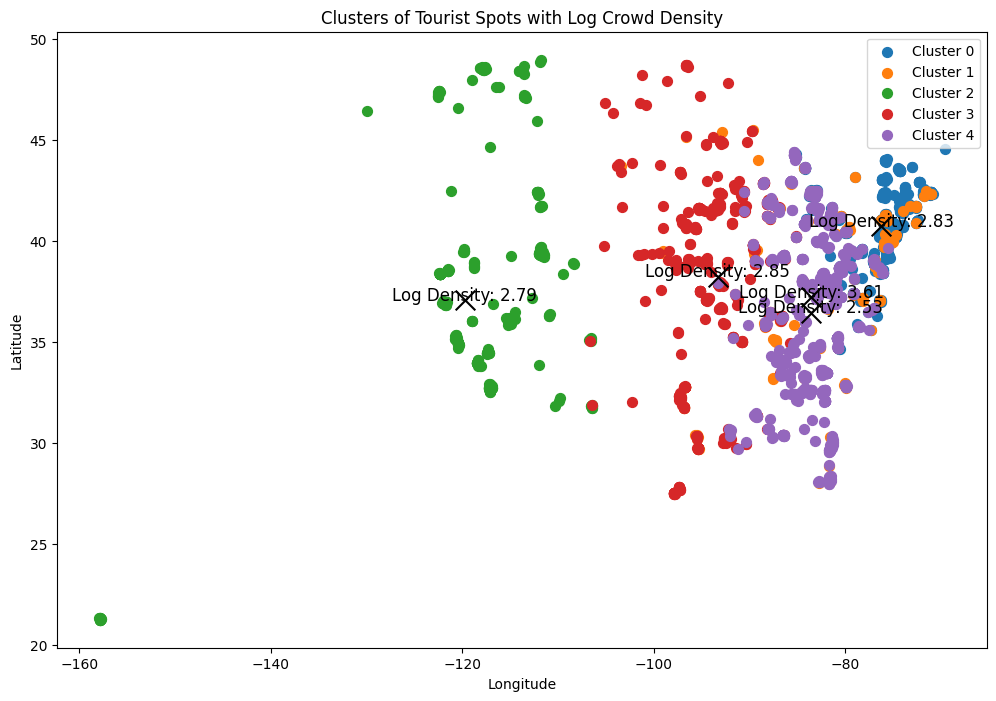

In [44]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X_kmeans = df_cleaned[['latitude', 'longitude', 'overall_avg_popularity']]

n_clusters = 5  
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_cleaned['cluster'] = kmeans.fit_predict(X_kmeans)

inertia = kmeans.inertia_  
silhouette_avg = silhouette_score(X_kmeans, df_cleaned['cluster'])  

print("Inertia (Sum of Squared Distances):", inertia)
print("Silhouette Score:", silhouette_avg)

cluster_centers = kmeans.cluster_centers_
cluster_centers_log = np.copy(cluster_centers)
cluster_centers_log[:, 2] = np.log(cluster_centers[:, 2] + 1e-10)  
plt.figure(figsize=(12, 8))

for i in range(n_clusters):
    cluster_points = df_cleaned[df_cleaned['cluster'] == i]
    plt.scatter(cluster_points['longitude'], cluster_points['latitude'], s=50, label=f'Cluster {i}')

for i, center in enumerate(cluster_centers_log):
    plt.scatter(center[1], center[0], s=200, color='black', marker='x')  
    plt.text(center[1], center[0], f"Log Density: {center[2]:.2f}", fontsize=12, ha='center')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Clusters of Tourist Spots with Log Crowd Density")
plt.legend()
plt.show()